In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

In [3]:
df = pd.read_csv('campaign_data.csv')

In [4]:
df.head()

,CampaignID,GoalAmount,RaisedAmount,DurationDays,NumBackers,Category,LaunchMonth,Country,Currency,OwnerExperience,VideoIncluded,SocialMediaPresence,NumUpdates,IsSuccessful
0,CID_00000,76159,73518.028955,15,1903,Film,September,Australia,GBP,11,Yes,41758,3,0
1,CID_00001,69394,60068.683288,49,469,Art,October,Australia,GBP,7,Yes,79112,48,0
2,CID_00002,18652,22958.153470,58,148,Film,February,USA,EUR,17,No,3942,9,1
3,CID_00003,19487,24229.048390,39,780,Film,October,Germany,AUD,10,No,22047,35,1
4,CID_00004,26734,17984.630311,68,1622,Games,September,Australia,AUD,12,Yes,72568,17,0


## Data Preparation

In [5]:
df.columns = df.columns.str.replace(' ','_').str.lower()
string_columns = list(df.dtypes[df.dtypes == 'object'].index)
for c in string_columns:
    df[c] = df[c].str.lower()

In [6]:
df.columns

Index(['campaignid', 'goalamount', 'raisedamount', 'durationdays',
       'numbackers', 'category', 'launchmonth', 'country', 'currency',
       'ownerexperience', 'videoincluded', 'socialmediapresence', 'numupdates',
       'issuccessful'],
      dtype='object')

In [7]:
df = df.set_index('campaignid')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, cid_00000 to cid_99999
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   goalamount           100000 non-null  int64  
 1   raisedamount         100000 non-null  float64
 2   durationdays         100000 non-null  int64  
 3   numbackers           100000 non-null  int64  
 4   category             100000 non-null  object 
 5   launchmonth          100000 non-null  object 
 6   country              100000 non-null  object 
 7   currency             100000 non-null  object 
 8   ownerexperience      100000 non-null  int64  
 9   videoincluded        100000 non-null  object 
 10  socialmediapresence  100000 non-null  int64  
 11  numupdates           100000 non-null  int64  
 12  issuccessful         100000 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 10.7+ MB


## EDA

In [9]:
df.describe()

,goalamount,raisedamount,durationdays,numbackers,ownerexperience,socialmediapresence,numupdates,issuccessful
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,50538.001310,50598.121803,52.047370,1003.347340,9.489130,50077.301010,24.483230,0.500940
std,28613.822592,33255.277493,21.653238,574.485153,5.763538,28767.521522,14.413833,0.500002
min,1000.000000,528.632349,15.000000,10.000000,0.000000,100.000000,0.000000,0.000000
25%,25724.750000,23396.500017,33.000000,505.000000,4.000000,25276.750000,12.000000,0.000000
50%,50706.000000,45980.674476,52.000000,1003.000000,9.000000,50024.500000,25.000000,1.000000
75%,75316.000000,72790.183158,71.000000,1502.000000,14.000000,74934.250000,37.000000,1.000000
max,99999.000000,149238.361559,89.000000,1999.000000,19.000000,99999.000000,49.000000,1.000000


In [10]:
numerical_columns = list(df.dtypes[(df.dtypes == 'float64') | (df.dtypes == 'int64')].index)

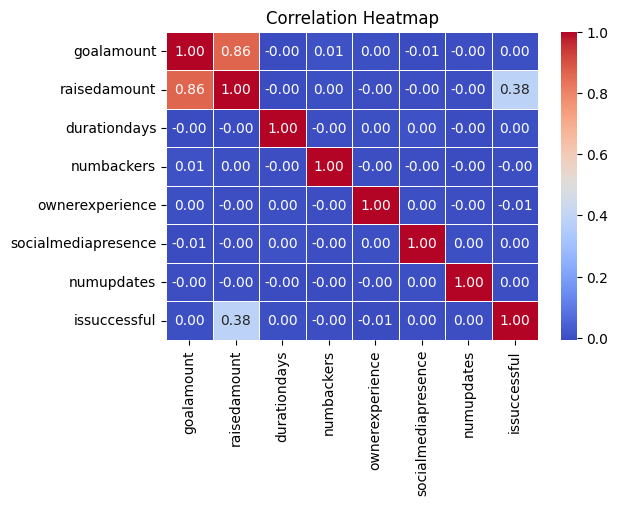

In [11]:
corr = df[numerical_columns].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [12]:
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
numerical_columns = list(df.dtypes[(df.dtypes == 'float64') | (df.dtypes == 'int64')].index)

In [13]:
numerical_columns.remove('issuccessful')

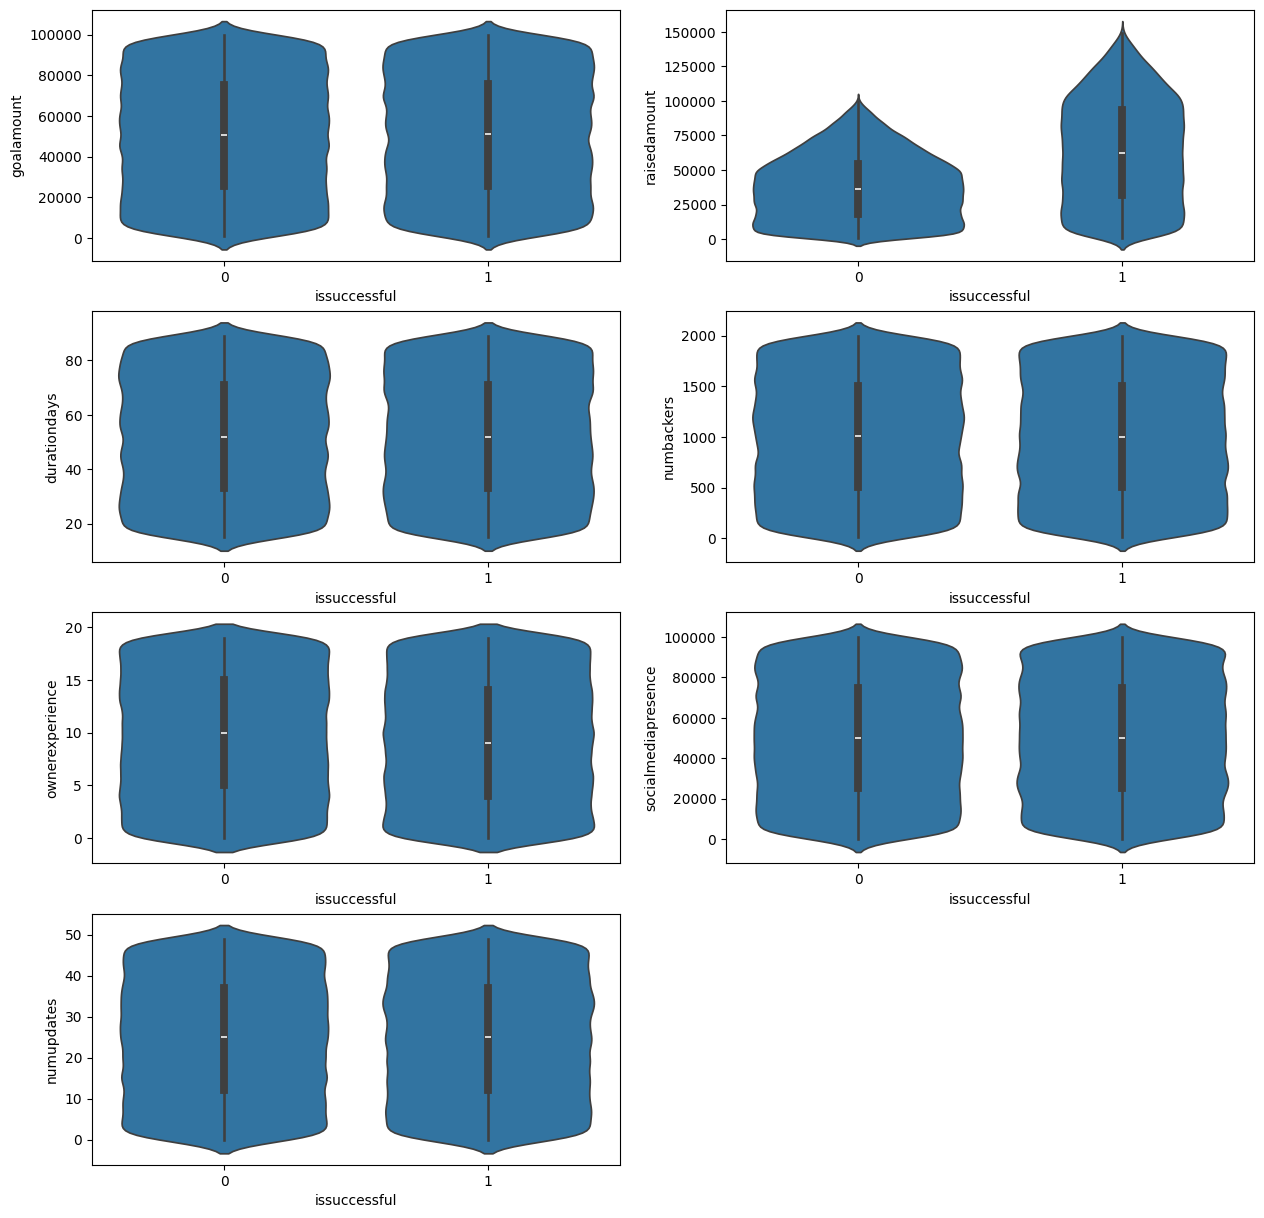

In [14]:
plt.figure(figsize = (15,15))
for i,n in enumerate(numerical_columns):
    ax = plt.subplot(4, 2, i+1)
    sns.violinplot(df, x = 'issuccessful', y = n, ax = ax)

In [15]:
df.issuccessful.value_counts(normalize = True)

issuccessful
1    0.50094
0    0.49906
Name: proportion, dtype: float64

## Model Training

In [16]:
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 1)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 1)

In [17]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [18]:
y_train = df_train.issuccessful
y_val = df_val.issuccessful
y_test = df_test.issuccessful

In [19]:
feature_columns = list(df.dtypes.index)[:-1]

In [20]:
train_dict = df_train[feature_columns].to_dict(orient = 'records')
val_dict = df_val[feature_columns].to_dict(orient = 'records')
test_dict = df_test[feature_columns].to_dict(orient = 'records')

In [21]:
dv = DictVectorizer(sparse = False)

In [22]:
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

In [23]:
import mlflow

mlflow.set_tracking_uri("http://127.0.0.1:8080")
mlflow.set_experiment("campaign_success_prediction")

<Experiment: artifact_location='mlflow-artifacts:/540004257869438950', creation_time=1721643979242, experiment_id='540004257869438950', last_update_time=1721643979242, lifecycle_stage='active', name='campaign_success_prediction', tags={}>

In [27]:
from tqdm import tqdm

In [28]:
n_estimators_range = range(10, 201, 10)
max_depth_range = [3, 5, 7, 10]
min_samples_leaf_range = [1, 3, 5, 10, 50]

for n_estimators in tqdm(n_estimators_range):
    for max_depth in max_depth_range:
        for min_samples_leaf in min_samples_leaf_range:
            with mlflow.start_run():
                mlflow.set_tag("mlops_project", "campaign_success_prediction")
                model = RandomForestClassifier(n_estimators=n_estimators,
                                               max_depth=max_depth,
                                               min_samples_leaf=min_samples_leaf)

                # Log model parameters
                mlflow.log_params({
                    "n_estimators": n_estimators,
                    "max_depth": max_depth,
                    "min_samples_leaf": min_samples_leaf
                })

                # Train the model
                model.fit(X_train, y_train)

                # Log metrics
                y_pred = model.predict(X_val)
                mlflow.log_metrics({
                    "accuracy": accuracy_score(y_val, y_pred),
                    "precision": precision_score(y_val, y_pred),
                    "recall": recall_score(y_val, y_pred),
                    "roc_auc": roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])
                })

100%|███████████████████████████████████████| 20/20 [21:22<00:00, 64.12s/it]


In [24]:
run = mlflow.get_run("461f39c7d7714a688e5dcbceb87317d6")

max_depth = run.data.params.get("max_depth")
min_samples_leaf = run.data.params.get("min_samples_leaf")
n_estimators = run.data.params.get("n_estimators")

print(f"max_depth: {max_depth}")
print(f"min_samples_leaf: {min_samples_leaf}")
print(f"n_estimators: {n_estimators}")

max_depth: 10
min_samples_leaf: 3
n_estimators: 110


In [31]:
# !mkdir models

In [28]:
full_train_dict = df_full_train[feature_columns].to_dict(orient = 'records')
y_full_train = df_full_train.issuccessful
y_test = df_test.issuccessful
X_full_train = dv.fit_transform(full_train_dict)
X_test = dv.transform(test_dict)

In [29]:
model = RandomForestClassifier(n_estimators=110,
                                    max_depth=10,
                                    min_samples_leaf=3)
model.fit(X_full_train, y_full_train)
y_pred = model.predict(X_test)

roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

np.float64(0.943309119782078)

In [30]:
import pickle
with mlflow.start_run():
    mlflow.set_tag("mlops_project", "campaign_success_prediction_final")
    model = RandomForestClassifier(n_estimators=110,
                                    max_depth=10,
                                    min_samples_leaf=3
                                  )
    model.fit(X_full_train, y_full_train)
    y_pred = model.predict(X_test)
    mlflow.log_metrics({
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    })
    with open('models/rf_clf.bin', 'wb') as f_out:
        pickle.dump(model, f_out)
    with open('models/dv.bin', 'wb') as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact(local_path="models/rf_clf.bin", artifact_path="models_pickle")
    mlflow.log_artifact(local_path="models/dv.bin", artifact_path="dv_pickle")